In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import pandas as pd
import time

from load_datasets import load_features
from dr_eval import run_eval

from sklearn.neighbors import NearestNeighbors

# Load datasets

In [3]:
datasets_names = ["rts", "pdl", "ioc", "mjf"]
datasets = load_features(datasets_names)

Features loaded:
rts: 638359 samples of dimension 2048
pdl: 27672 samples of dimension 99
ioc: 58313 samples of dimension 33
mjf: 39789 samples of dimension 87


In [ ]:
mnist_data = np.load('DATA/mnist_pca.npy', allow_pickle=True).reshape(70000, -1)
datasets["mnist"] = mnist_data

# Test DR

In [3]:
from sklearn.manifold import TSNE
from umap import UMAP
from trimap import TRIMAP
from pacmap import PaCMAP

In [6]:
PaCMAP?

Init signature:
PaCMAP(
    n_components=2,
    n_neighbors=10,
    MN_ratio=0.5,
    FP_ratio=2.0,
    pair_neighbors=None,
    pair_MN=None,
    pair_FP=None,
    distance='euclidean',
    lr=1.0,
    num_iters=(100, 100, 250),
    verbose=False,
    apply_pca=True,
    intermediate=False,
    intermediate_snapshots=[0, 10, 30, 60, 100, 120, 140, 170, 200, 250, 300, 350, 450],
    random_state=None,
    save_tree=False,
)
Docstring:     
Pairwise Controlled Manifold Approximation.

Maps high-dimensional dataset to a low-dimensional embedding.
This class inherits the sklearn BaseEstimator, and we tried our best to
follow the sklearn api. For details of this method, please refer to our publication:
https://www.jmlr.org/papers/volume22/20-1061/20-1061.pdf

Parameters
---------
n_components: int, default=2
    Dimensions of the embedded space. We recommend to use 2 or 3.

n_neighbors: int, default=10
    Number of neighbors considered for nearest neighbor pairs for local structure preser

In [5]:
dr_algos = {
    "tsne": TSNE(n_components=2),
    "umap": UMAP(n_components=2),
    "trimap": TRIMAP(n_dims=2),
    "pacmap": PaCMAP(n_components=2)
}

algo_names = list(dr_algos.keys())

In [6]:
def run_dr(X, nn, dataset_name, algo_name, 
           N_SAMPLE = -1, 
           n_eval_runs = 1, 
           n_sample = 1000, 
           n_repetitions = 10, 
           n_neighbors = 100, 
           RUN_EVALUATION = True,
           SAVE_EMBEDDINGS = False):   
    
    embeddings_path = f"embeddings/embeddings_{dataset_name}_{algo_name}_N{N_SAMPLE}.npy"    
        
    evaluation_results = {}    
    if not RUN_EVALUATION:
        n_eval_runs = 1
        print("Evaluation is turned off. Only DR embeddings will be computed.")
        if os.path.exists(embeddings_path):
            print("Embeddings already computed. Loading...")
            return {f"{dataset_name}_{algo_name}": np.load(embeddings_path)}
        
    algo = dr_algos[algo_name]
    embeddings = []
    csv_path = f"results/{dataset_name}/eval_{dataset_name}_{algo_name}_N{N_SAMPLE}.csv"
    for i in range(n_eval_runs):
        # Compute DR embedding
        time_start = time.time()
        embedding = algo.fit_transform(X)
        time_stop = time.time()
        embeddings.append(embedding)
        
        # Run evaluation
        if RUN_EVALUATION:
            eval_results = run_eval(X_high = X, 
                                    X_low = embedding,
                                    neighbors_high = nn, 
                                    n_sample = n_sample,
                                    n_repetitions = n_repetitions,
                                    neighborhood_size = n_neighbors, 
                                    run_drmetrics = False)
            eval_results["run_time"] = time_stop - time_start
            # Save evaluation settings
            eval_results["eval_settings"] = {
                "n_points":X.shape[0],
                "n_neighbors":n_neighbors,
                "n_sample":n_sample,
                "n_repetitions":n_repetitions,
                "n_eval_runs":n_eval_runs
            }
            evaluation_results[f"{dataset_name}_{algo_name}_run{i}"] = eval_results
        
        if RUN_EVALUATION:
            evaluation_results_df = pd.DataFrame(evaluation_results).T.reset_index()
            evaluation_results_df.to_csv(csv_path, index=False)
    
        if SAVE_EMBEDDINGS:
            np.save(embeddings_path, embeddings[-1])
    
    return {f"{dataset_name}_{algo_name}": embeddings[-1]}

In [7]:
def run_dr_on_dataset(dataset_name, 
                      N_SAMPLE = -1, 
                      n_eval_runs = 1, 
                      n_sample = 1000, 
                      n_repetitions = 10, 
                      n_neighbors = 100, 
                      RUN_EVALUATION = True,
                      SAVE_EMBEDDINGS = False):
    # Create folder and path to save results
    if not os.path.exists(f"results/{dataset_name}"):
        os.makedirs(f"results/{dataset_name}")
    
    # Load data. N_SAMPLE points can be used to speed up computation
    X = datasets[dataset_name]
    if N_SAMPLE > 0 and N_SAMPLE < X.shape[0]:
        rng = np.random.default_rng(42)
        X = X[rng.choice(X.shape[0], N_SAMPLE, replace=False)]
    
    print(f"---Starting evaluation for dataset {dataset_name} with {X.shape[0]} points---")
    
    # Compute high-dimensional nearest neighbors
    nn = None
    if RUN_EVALUATION:
        knn_high = NearestNeighbors(n_neighbors=n_neighbors+1, n_jobs=-1).fit(X)
        nn = knn_high.kneighbors(X, n_neighbors=n_neighbors+1, return_distance=False) 
    
    results = {}
    for algo_name in algo_names:
        time_start = time.time()
        results.update(run_dr(X, nn, dataset_name, algo_name, N_SAMPLE, n_eval_runs, n_sample, n_repetitions, n_neighbors, RUN_EVALUATION, SAVE_EMBEDDINGS))
        print(f"---Completed {algo_name} for dataset {dataset_name} in {time.time() - time_start}---")
    return results

In [ ]:
embeddings = {}

for dataset in ["rts", "pdl", "ioc", "mjf"]:
    results = run_dr_on_dataset(dataset, 
                                N_SAMPLE = 60000, 
                                n_eval_runs = 1, 
                                n_sample = 1000, 
                                n_repetitions = 10, 
                                n_neighbors = 100, 
                                RUN_EVALUATION = False,
                                SAVE_EMBEDDINGS = True)
    embeddings.update(results)

In [ ]:
mnist_embeddings = {}
dataset_name = "mnist"
N_SAMPLE = 70000

# Create folder and path to save results
if not os.path.exists(f"results/{dataset_name}"):
    os.makedirs(f"results/{dataset_name}")

# Load data. N_SAMPLE points can be used to speed up computation
X = datasets[dataset_name]
if N_SAMPLE > 0 and N_SAMPLE < X.shape[0]:
    rng = np.random.default_rng(42)
    X = X[rng.choice(X.shape[0], N_SAMPLE, replace=False)]

print(f"---Starting evaluation for dataset {dataset_name} with {X.shape[0]} points---")

n_neighbors = 50
knn_high = NearestNeighbors(n_neighbors=n_neighbors+1, n_jobs=-1).fit(X)
nn = knn_high.kneighbors(X, n_neighbors=n_neighbors+1, return_distance=False)

for algo in ["umap", "trimap", "pacmap"]:
    dataset_embeddings = run_dr(X, nn, 
                                dataset_name,
                                algo, 
                                N_SAMPLE = 70000, 
                                n_eval_runs = 5, 
                                n_sample = 1000, 
                                n_repetitions = 100, 
                                n_neighbors = n_neighbors, 
                                RUN_EVALUATION = True)
    mnist_embeddings.update(dataset_embeddings)

### Load embeddings

In [8]:
embeddings = {}

for dataset in ["rts", "pdl", "ioc", "mjf"]:
    results = run_dr_on_dataset(dataset, 
                                N_SAMPLE = 60000, 
                                n_eval_runs = 1, 
                                n_sample = 1000, 
                                n_repetitions = 10, 
                                n_neighbors = 100, 
                                RUN_EVALUATION = False,
                                SAVE_EMBEDDINGS = True)
    embeddings.update(results)

---Starting evaluation for dataset rts with 60000 points---
Evaluation is turned off. Only DR embeddings will be computed.
Embeddings already computed. Loading...
---Completed tsne for dataset rts in 0.008499860763549805---
Evaluation is turned off. Only DR embeddings will be computed.
Embeddings already computed. Loading...
---Completed umap for dataset rts in 0.007139444351196289---
Evaluation is turned off. Only DR embeddings will be computed.
Embeddings already computed. Loading...
---Completed trimap for dataset rts in 0.004819631576538086---
Evaluation is turned off. Only DR embeddings will be computed.
Embeddings already computed. Loading...
---Completed pacmap for dataset rts in 0.004217863082885742---
---Starting evaluation for dataset pdl with 27672 points---
Evaluation is turned off. Only DR embeddings will be computed.
Embeddings already computed. Loading...
---Completed tsne for dataset pdl in 0.0037419795989990234---
Evaluation is turned off. Only DR embeddings will be co

In [ ]:
d = 3
b = 0.01 # border of zoomed in region plot
n_rows = len(datasets_names)
n_cols = len(algo_names)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(d * n_cols, d * n_rows))
for i, dataset in enumerate(datasets_names):
    for j, algo_name in enumerate(algo_names):
        ax = axs[i, j]
        ax.scatter(embeddings[f"{dataset}_{algo_name}"][:, 0], embeddings[f"{dataset}_{algo_name}"][:, 1], s=0.005)
        #ax.set_title(f"{dataset} - {algo_name}", fontsize=10, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(dataset.upper(), fontsize=14, fontweight='bold')
        if i == 0:
            ax.set_title(algo_name.upper(), fontsize=14, fontweight='bold')
        
        # Add zoomed in region for rts_trimap and ioc_trimap
        if dataset == "rts" and algo_name == "trimap":
            x_min, x_max = -1500, 1500
            y_min, y_max = -2000, 3500
            w = 0.8 # width of zoomed in region
            h = w * (x_max - x_min) / (y_max - y_min) 
            axins = ax.inset_axes([b, 1 - h - b, w, h]) 
            axins.scatter(embeddings[f"{dataset}_{algo_name}"][:, 0], embeddings[f"{dataset}_{algo_name}"][:, 1], s=0.05, alpha = 0.5)
            axins.set_xlim(x_min, x_max)
            axins.set_ylim(y_min, y_max)
            axins.set_xticks([])
            axins.set_yticks([])
            ax.indicate_inset_zoom(axins, edgecolor="red")
        if dataset == "ioc" and algo_name == "trimap":
            x_min, x_max = -75, 100
            y_min, y_max = -150, 100
            h = 0.4 # height of zoomed in region
            w = h * (y_max - y_min) / (x_max - x_min)  
            axins = ax.inset_axes([1 - w - b, b, w, h])
            axins.scatter(embeddings[f"{dataset}_{algo_name}"][:, 0], embeddings[f"{dataset}_{algo_name}"][:, 1], s=0.05, alpha = 0.5)
            axins.set_xlim(x_min, x_max)
            axins.set_ylim(y_min, y_max)
            axins.set_xticks([])
            axins.set_yticks([])
            ax.indicate_inset_zoom(axins, edgecolor="red")
        
plt.tight_layout()
plt.show()

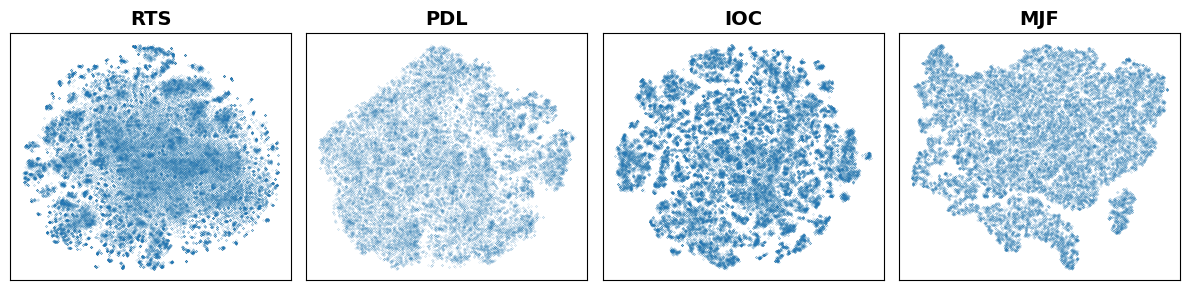

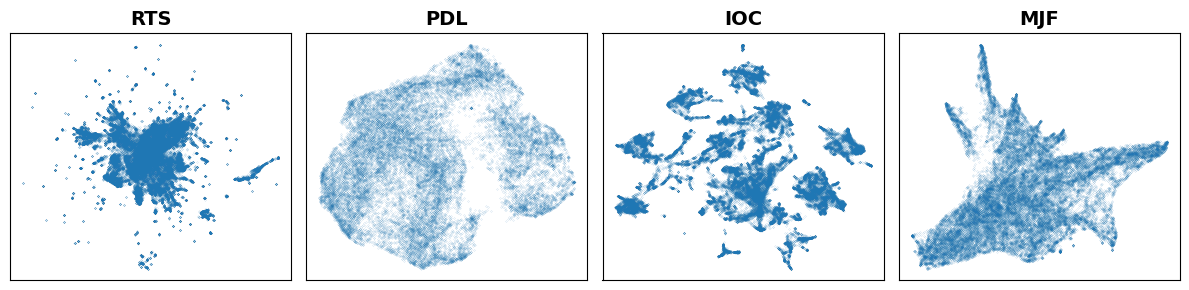

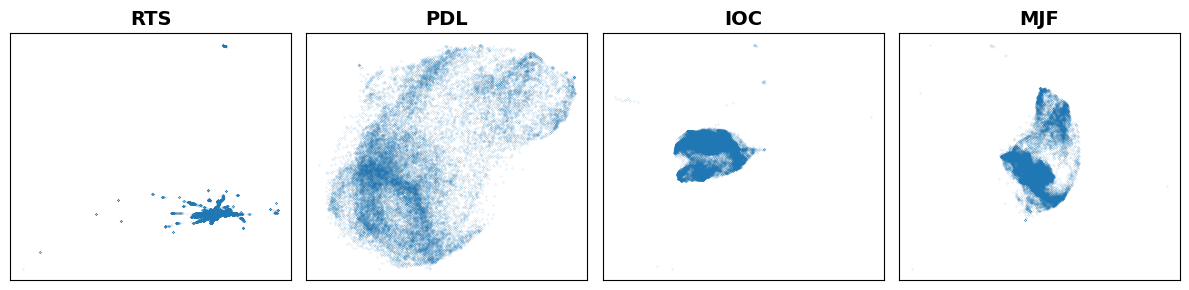

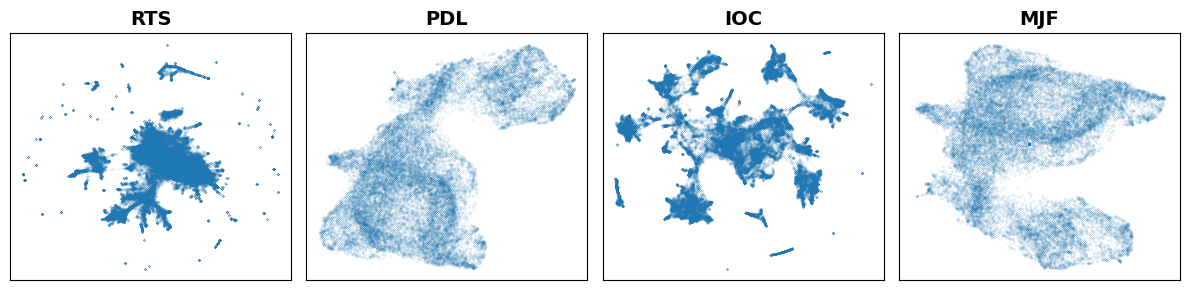

In [9]:
# Create 4 plots, one for each algorithm
d = 3
n_cols = len(datasets_names)

for i,algo in enumerate(algo_names):
    fig, axs = plt.subplots(1, n_cols, figsize=(d * n_cols, d))
    for j, dataset in enumerate(datasets_names):
        ax = axs[j]
        ax.scatter(embeddings[f"{dataset}_{algo}"][:, 0], embeddings[f"{dataset}_{algo}"][:, 1], s=0.005)
        ax.set_title(dataset.upper(), fontsize=14, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()
